# Prediction of Customers Loan Default Risk

This project aims to find and predict a customers default risk in loan repayment based on base factors and trends.

It is a Binary Classification task and to proffer a solution, models that can handle such tasks will be adopted, trained and evaluated, prioritizing **performance** and **interpretability**.

#### Key Technologies
1. Data Cleaning
2. Exploratory Data Analysis
3. Modeling

In [1]:
# install libraries
!pip install category_encoders --quiet


In [2]:
!pip install streamlit --quiet

In [3]:
# import necessary libraries

# Data Handling and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Library for Age Calculation
from datetime import date

# Libraries for Reverse Geocoding
import requests
import time
from getpass import getpass
import os

# Libraries For Map Visualization
import folium

# Libraries for Data Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from category_encoders import HashingEncoder
from sklearn.impute import SimpleImputer

# Libraries for Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn.metrics import roc_curve, auc,precision_recall_curve, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import shap
# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint
# saving model
import joblib
# deploy
import streamlit as st

In [4]:
prev = pd.read_csv('https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainprevloans.csv', parse_dates=[3, 4,8,10,11])
demo  = pd.read_csv('https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/traindemographics.csv', parse_dates=[1])
perf = pd.read_csv('https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainperf.csv', parse_dates=[3,4])

## Data Cleaning

### Cleaning the First Dataset (Customer Demographics)

In [5]:
demo.sample(10)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
3978,8a858ef759ffbd8a0159ffea48b311e8,1980-06-01,Savings,3.904861,7.320892,First Bank,NaN,Permanent,NaN
1611,8a858faf56b7821c0156bc7a2d156c16,1992-08-29,Savings,4.456850,7.699752,Zenith Bank,NaN,NaN,NaN
2663,8a858eda552adcc2015548f0eb523fc3,1988-09-15,Other,3.301623,6.493803,GT Bank,NaN,Permanent,NaN
856,8a858f2d5853901a01586650578e325f,1986-03-19,Savings,56.342638,25.351997,Fidelity Bank,NaN,Permanent,NaN
1312,8a858fd25c5a5bc7015c5dea03764080,1979-01-20,Savings,3.312925,7.119599,GT Bank,NaN,Permanent,NaN
2540,8a858ecc57b9184b0157bd7491b650ec,1978-02-16,Savings,3.525146,6.668493,GT Bank,"47 LAGOS ROAD, IKORODU",Permanent,Secondary
176,8a858f54589736f401589857085e3b5b,1992-01-28,Savings,4.516451,7.522191,Access Bank,NaN,Student,NaN
989,8a858f6e5cb16eb9015cbf6316b4273f,1989-11-28,Savings,3.440563,6.436981,Zenith Bank,NaN,NaN,NaN
4059,8a858f535908095c01591628b8dc27b1,1981-02-03,Savings,6.810148,6.094645,First Bank,NaN,Permanent,NaN
1399,8a858eed5a476a3c015a48d4049172e3,1990-12-19,Savings,3.373062,7.171593,GT Bank,NaN,Permanent,NaN


In [6]:
demo.shape

(4346, 9)

In [7]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  4346 non-null   object        
 1   birthdate                   4346 non-null   datetime64[ns]
 2   bank_account_type           4346 non-null   object        
 3   longitude_gps               4346 non-null   float64       
 4   latitude_gps                4346 non-null   float64       
 5   bank_name_clients           4346 non-null   object        
 6   bank_branch_clients         51 non-null     object        
 7   employment_status_clients   3698 non-null   object        
 8   level_of_education_clients  587 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 305.7+ KB


In [8]:
# check for duplicates
dupe = [col for col in demo.columns if demo[col].duplicated().any()]
print(dupe)

demo.drop_duplicates(inplace=True)

['customerid', 'birthdate', 'bank_account_type', 'longitude_gps', 'latitude_gps', 'bank_name_clients', 'bank_branch_clients', 'employment_status_clients', 'level_of_education_clients']


There are duplicates in all the columns. Mainly because there are duplicated *customerid* data, and consequentially, other columns are repeated.

Instead of handling the duplicates now, i would merge the datasets firsts to see if the duplicates would disappear/reduce.


In [9]:
demo.shape

(4334, 9)

- Handling Missing Values

In [10]:
demo.isna().sum()

,0
customerid,0
birthdate,0
bank_account_type,0
longitude_gps,0
latitude_gps,0
bank_name_clients,0
bank_branch_clients,4283
employment_status_clients,648
level_of_education_clients,3748


In [11]:
demo.level_of_education_clients.unique()

array([nan, 'Secondary', 'Graduate', 'Post-Graduate', 'Primary'],
      dtype=object)

In [12]:
demo.fillna({'level_of_education_clients': demo['level_of_education_clients'].mode()[0]}, inplace=True)

In [13]:
demo.level_of_education_clients.unique()

array(['Graduate', 'Secondary', 'Post-Graduate', 'Primary'], dtype=object)

In [14]:
demo['level_of_education_clients'] =demo['level_of_education_clients'].replace('None', 'Graduate')

In [15]:
demo.fillna({'employment_status_clients':  demo['employment_status_clients'].mode()[0]}, inplace=True)

In [16]:
demo.employment_status_clients.unique()

array(['Permanent', 'Student', 'Self-Employed', 'Unemployed', 'Retired',
       'Contract'], dtype=object)

In [17]:
demo['employment_status_clients'] = demo['employment_status_clients'].replace('None', 'Self-Employed')



*   To handle the missing values in *bank_branch_clients* column, i would use reverse geocoding later in the code, to get the state and country to fill all miissing values



In [18]:
demo.bank_branch_clients.unique()

array([nan, 'LAGOS', 'LADIPO', 'AWOLOWO', 'OGBA', 'AJOSE ADEOGUN',
       'ABULE EGBA', 'OREGUN', 'ABEOKUTA', 'TRANS AMADI',
       'OBA AKRAN BERGER PAINT', 'APAPA', 'BOSSO ROAD, MINNA',
       'DUGBE, IBADAN', 'ALAUSA', 'OJUELEGBA', 'MUSHIN BRANCH', 'AKUTE',
       'OBA ADEBIMPE', 'STERLING BANK PLC 102, IJU ROAD, IFAKO BRANCH',
       'MEDICAL ROAD IKEJA', 'ADENIRAN OGUNSANYA', 'OBA AKRAN',
       '40,SAPELE ROAD ,OPPOSITE DUMAZ JUNCTION BENIN CITY EDO STATE.',
       'ACCESS BANK PLC, CHALLENGE ROUNDABOUT IBADAN, OYO STATE.',
       'ABULE EGBA U-TURN,BRANCH', 'OGUDU, OJOTA',
       'OBA AKRAN ROAD, IKEJA,', '47 LAGOS ROAD, IKORODU', 'OAU ILE IFE',
       'RING ROAD',
       'PLOT 999C DANMOLE STREET, ADEOLA ODEKU, VICTORIA ISLAND, LAGOS',
       'HERITAGE BANK, DUGBE, IBADAN', 'ADEOLA HOPEWELL',
       'WHARF ROAD, APAPA', 'ILUPEJU', 'AKOWONJO', 'DUGBE,IBADAN',
       'HEAD OFFICE', 'GBAGADA', 'LEKKI EPE', 'MAFOLUKU', 'AKURE BRANCH',
       '17, SANUSI FAFUNWA STREET, VICTORIA ISL

### Cleaning the Second Dataset (Performance)

In [19]:
perf.shape

(4368, 10)

- Find & handle missing values

In [20]:
perf.isna().sum()

,0
customerid,0
systemloanid,0
loannumber,0
approveddate,0
creationdate,0
loanamount,0
totaldue,0
termdays,0
referredby,3781
good_bad_flag,0


In [21]:
perf.drop(columns=['referredby'], inplace=True)

### Cleaning the Third Dataset (Previous Loans)

In [22]:
prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.0,11500.0,15,2017-04-24 01:35:52,NaN,2017-04-24,2017-04-24 00:48:43
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.0,11500.0,15,2017-07-14 21:18:43,NaN,2017-07-03,2017-07-14 21:08:35


In [23]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customerid       18183 non-null  object        
 1   systemloanid     18183 non-null  int64         
 2   loannumber       18183 non-null  int64         
 3   approveddate     18183 non-null  datetime64[ns]
 4   creationdate     18183 non-null  datetime64[ns]
 5   loanamount       18183 non-null  float64       
 6   totaldue         18183 non-null  float64       
 7   termdays         18183 non-null  int64         
 8   closeddate       18183 non-null  datetime64[ns]
 9   referredby       1026 non-null   object        
 10  firstduedate     18183 non-null  datetime64[ns]
 11  firstrepaiddate  18183 non-null  datetime64[ns]
dtypes: datetime64[ns](5), float64(2), int64(3), object(2)
memory usage: 1.7+ MB


In [24]:
prev.isna().sum()

,0
customerid,0
systemloanid,0
loannumber,0
approveddate,0
creationdate,0
loanamount,0
totaldue,0
termdays,0
closeddate,0
referredby,17157


Because the **Previous Loans** dataset is a record of customers past borrowing and repayment transactions, using feature engineering, i would:
1. Create a credit score column so it would find the credit score of each customer based on their previous transactions, then aggregate it.
2. Calculate the ratio of loan amount to the total loan amount due using *loanamount* and *totaldue*, and then find the aggregate.
3. Calculate how frequent a customer takes loans.

2. Merge credit score column, loan ratio column, and loan frequency column, with the other two datasets using *customerid*.

#### 1. Calculate Credit Score

**Score Range** = 300 - 850

Using the columns *firstduedate*, *termdays*, and *firstrepaiddate*, the logic to calculate the credit score is as follows:
- Define a function that would be applied to dataset
- Within the function, there's an **if statement** for scoring a customer based on the difference between the due date and repayment date and the term days
- if the difference between the due and repayment date is less than the term days, then it is early/ on time payment
- if the difference between the due and repayment date exceeds term days, then it would be a negative scoring.
- for accuracy, the score would be scaled based on how close the repayment date is to due date

In [25]:
def creditScoring(row):
  repayment_diff = abs((row['firstrepaiddate'] - row['firstduedate']).days)

  if repayment_diff > row['termdays']:
        score = 300  # Very poor
  else:
       # Scale score based on how close repayment is to due date
        score = 850 - int((repayment_diff / row['termdays']) * 550)
        score = max(300, min(score, 850))
  return round(score)

prev['credit score'] = prev.apply(creditScoring, axis = 1)

#### 2. Calculate loanamount to total due ratio.
with provision for if the totaldue is 0 so i don't have infinite values there

In [26]:
prev['loan_to_due_ratio'] = prev['loanamount']/prev['totaldue']

prev['loan_to_due_ratio'] = prev['loan_to_due_ratio'].replace([float('inf'), -float('inf')], pd.NA).round(2)

### 3. Calculate how often a customer takes loans

In [27]:
prev['loan_freq'] = prev.groupby('customerid')['systemloanid'].transform('count')


#### 4. Create a new dataset by grouping entries by customerid

In [28]:
# group by customerid and calculate the average credit score per customer
new_dataset = prev.groupby('customerid').agg({'credit score': 'mean',
                                                     'loan_freq':'max',
                                                     'loan_to_due_ratio': 'mean'})

In [29]:
# round up the average score to the nearest whole number
new_dataset['credit score'] = np.ceil(new_dataset['credit score']).astype(int)

In [30]:
new_dataset['loan_to_due_ratio'] = new_dataset['loan_to_due_ratio'].round(2)

In [31]:
new_dataset.head()

,credit score,loan_freq,loan_to_due_ratio
customerid,,,
8a1088a0484472eb01484669e3ce4e0b,630,1,0.87
8a1a1e7e4f707f8b014f797718316cad,839,4,0.78
8a1a32fc49b632520149c3b8fdf85139,830,7,0.86
8a1eb5ba49a682300149c3c068b806c7,766,8,0.80
8a1edbf14734127f0147356fdb1b1eb2,777,2,0.82


### Merge all Three Datasets using Inner join on the customerid

merge first two datasets
- customer demographic data
- performance data

In [32]:
first_merge = pd.merge( demo, perf,  on='customerid', how='inner')

merge the *first_merge* dataset with the *new_dataset* (the one containing the credit score information)

In [33]:
loan_data = pd.merge(first_merge, new_dataset, on='customerid', how='inner')

In [34]:
loan_data

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,credit score,loan_freq,loan_to_due_ratio
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,Permanent,Graduate,301964962,2,2017-07-05 14:29:48,2017-07-05 13:29:42,10000.0,13000.0,30,Good,814,1,0.87
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,Graduate,301972172,2,2017-07-10 21:21:46,2017-07-10 20:21:40,10000.0,13000.0,30,Bad,795,1,0.77
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,Permanent,Graduate,301976271,4,2017-07-13 15:40:27,2017-07-13 14:40:19,10000.0,13000.0,30,Good,747,3,0.84
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,Graduate,301997763,2,2017-07-26 21:03:17,2017-07-26 20:03:09,10000.0,11500.0,15,Good,300,1,0.87
4,8a858ea05a859123015a8892914d15b7,1990-07-21,Savings,3.365935,6.564823,Access Bank,NaN,Permanent,Graduate,301992494,6,2017-07-23 21:44:43,2017-07-23 20:44:36,20000.0,24500.0,30,Good,792,5,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259,8a858f735b437619015b437bf3d30bdc,1982-10-19,Savings,3.306874,6.669184,GT Bank,NaN,Permanent,Graduate,301978422,3,2017-07-14 22:08:22,2017-07-14 21:07:13,10000.0,11500.0,15,Bad,777,2,0.87
3260,8a858fc45c5f93be015c61e0e5e55e38,1986-02-16,Savings,3.353483,6.651007,GT Bank,NaN,Permanent,Graduate,301981333,3,2017-07-17 08:52:06,2017-07-17 07:52:00,10000.0,11500.0,15,Good,722,2,0.87
3261,8a85897353d85af80153d8a368020159,1983-06-07,Other,7.046360,5.499944,UBA,NaN,Self-Employed,Graduate,301971930,11,2017-07-10 18:04:26,2017-07-10 17:04:21,40000.0,44000.0,30,Good,777,10,0.87
3262,8a858f155554552501555588ca2b3b40,1985-12-13,Other,3.236753,7.030168,Stanbic IBTC,NaN,Permanent,Graduate,301990956,7,2017-07-22 16:07:16,2017-07-22 15:07:02,20000.0,24500.0,30,Good,799,6,0.80


In [35]:
loan_data.isna().sum()

,0
customerid,0
birthdate,0
bank_account_type,0
longitude_gps,0
latitude_gps,0
bank_name_clients,0
bank_branch_clients,3234
employment_status_clients,0
level_of_education_clients,0
systemloanid,0


#### Reverse Geocoding to Handle Missing Values in '*bank_branch_clients*'

Using the **Google Geocoding** API, I would:
- Obtain the latitude and longitude coordinates of each row (each customer bank client location)
- Get the bank branch address (reverse geocoding)
- Extract and store the **state** and **country** information, in columns *bank_branch_state*, and *bank_branch_country*, respectively, for further analysis & interpretation
- Drop *bank_branch_clients* column

In [36]:

os.environ['GOOGLE_API_KEY'] =getpass('Enter Google API Key: ')
BASE_URL = "https://maps.googleapis.com/maps/api/geocode/json"
API_KEY = os.getenv('GOOGLE_API_KEY')

# function for reverse geocoding
def reverse_geocode(lat, lon, retries=3, delay=1, pace=0.1):
    url =f"{BASE_URL}?latlng={lat},{lon}&key={API_KEY}"

    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=10)
            time.sleep(pace)
            if response.status_code == 200:
                data = response.json()
                # Extract state and country
                results = data.get('results', [])
                if results:
                    address_components = results[0].get('address_components', [])
                    state = country = None
                    for component in address_components:
                        types = component['types']
                        if 'administrative_area_level_1' in types:
                          state = component['long_name']
                        elif 'locality' in types and not state:
                          state= component['long_name']
                        elif 'administrative_area_level_2' in types and not state:
                          state= component['long_name']
                        if 'country' in component['types']:
                             country = component['long_name']

                    return state, country
            else:
                time.sleep(delay)
        except requests.exceptions.RequestException:
            time.sleep(delay)

    return None, None

# apply to the loan_data dataset
loan_data[["bank_branch_state", "bank_branch_country"]] = loan_data.apply(
    lambda row: pd.Series(reverse_geocode(row["latitude_gps"], row["longitude_gps"])),
    axis=1
)


Enter Google API Key: ··········


In [37]:
 loan_data = loan_data.drop(columns='bank_branch_clients')

In [38]:
loan_data

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,systemloanid,loannumber,...,creationdate,loanamount,totaldue,termdays,good_bad_flag,credit score,loan_freq,loan_to_due_ratio,bank_branch_state,bank_branch_country
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,Permanent,Graduate,301964962,2,...,2017-07-05 13:29:42,10000.0,13000.0,30,Good,814,1,0.87,Lagos,Nigeria
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Permanent,Graduate,301972172,2,...,2017-07-10 20:21:40,10000.0,13000.0,30,Bad,795,1,0.77,Ogun State,Nigeria
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Permanent,Graduate,301976271,4,...,2017-07-13 14:40:19,10000.0,13000.0,30,Good,747,3,0.84,Delta,Nigeria
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,Permanent,Graduate,301997763,2,...,2017-07-26 20:03:09,10000.0,11500.0,15,Good,300,1,0.87,Lagos,Nigeria
4,8a858ea05a859123015a8892914d15b7,1990-07-21,Savings,3.365935,6.564823,Access Bank,Permanent,Graduate,301992494,6,...,2017-07-23 20:44:36,20000.0,24500.0,30,Good,792,5,0.79,Lagos,Nigeria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259,8a858f735b437619015b437bf3d30bdc,1982-10-19,Savings,3.306874,6.669184,GT Bank,Permanent,Graduate,301978422,3,...,2017-07-14 21:07:13,10000.0,11500.0,15,Bad,777,2,0.87,Lagos,Nigeria
3260,8a858fc45c5f93be015c61e0e5e55e38,1986-02-16,Savings,3.353483,6.651007,GT Bank,Permanent,Graduate,301981333,3,...,2017-07-17 07:52:00,10000.0,11500.0,15,Good,722,2,0.87,Lagos,Nigeria
3261,8a85897353d85af80153d8a368020159,1983-06-07,Other,7.046360,5.499944,UBA,Self-Employed,Graduate,301971930,11,...,2017-07-10 17:04:21,40000.0,44000.0,30,Good,777,10,0.87,Imo,Nigeria
3262,8a858f155554552501555588ca2b3b40,1985-12-13,Other,3.236753,7.030168,Stanbic IBTC,Permanent,Graduate,301990956,7,...,2017-07-22 15:07:02,20000.0,24500.0,30,Good,799,6,0.80,Ogun State,Nigeria


### Data Preparation
- Drop irrelavant columns
- Feature engineering (age, age group)
- missing values
- handle duplicates

In [39]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  3264 non-null   object        
 1   birthdate                   3264 non-null   datetime64[ns]
 2   bank_account_type           3264 non-null   object        
 3   longitude_gps               3264 non-null   float64       
 4   latitude_gps                3264 non-null   float64       
 5   bank_name_clients           3264 non-null   object        
 6   employment_status_clients   3264 non-null   object        
 7   level_of_education_clients  3264 non-null   object        
 8   systemloanid                3264 non-null   int64         
 9   loannumber                  3264 non-null   int64         
 10  approveddate                3264 non-null   datetime64[ns]
 11  creationdate                3264 non-null   datetime64[n

In [40]:
loan_data.isna().sum()

,0
customerid,0
birthdate,0
bank_account_type,0
longitude_gps,0
latitude_gps,0
bank_name_clients,0
employment_status_clients,0
level_of_education_clients,0
systemloanid,0
loannumber,0


In [41]:
loan_data = loan_data.dropna(subset=['bank_branch_state', 'bank_branch_country']).copy()

In [42]:
loan_data.duplicated().sum()

np.int64(0)

### Feature Engineering
- Age
- Age group


In [43]:
def cust_age(birthdate):
  today = date.today()
  age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
  return age

loan_data['age'] = loan_data.apply(lambda row: cust_age(row['birthdate']), axis=1)

In [44]:
loan_data.age.min()

29

In [45]:
loan_data.age.max()

63

In [46]:
# feature engineer age groups
def age_group(age):
  if 29 >= age <= 30:
    return 'Young Adult'
  elif 31 >= age <= 45:
    return 'Middle-aged Adult'
  else:
    return 'Old-aged Adult'

loan_data['age group'] = loan_data.apply(lambda row: age_group(row['age']), axis=1)

In [47]:
loan_data.columns.tolist()

['customerid',
 'birthdate',
 'bank_account_type',
 'longitude_gps',
 'latitude_gps',
 'bank_name_clients',
 'employment_status_clients',
 'level_of_education_clients',
 'systemloanid',
 'loannumber',
 'approveddate',
 'creationdate',
 'loanamount',
 'totaldue',
 'termdays',
 'good_bad_flag',
 'credit score',
 'loan_freq',
 'loan_to_due_ratio',
 'bank_branch_state',
 'bank_branch_country',
 'age',
 'age group']

In [48]:
# # drop irrelevant columns
# loan_data = loan_data.drop(columns=
#  ['customerid','birthdate','systemloanid','loannumber', 'approveddate', 'creationdate',]
#  )

In [49]:
# merge and export dataset
loan_data.to_csv('Cleaned Loan Default Dataset.csv', index=False)

## Exploratory Data Analysis

### 1. Numerical Columns
- Distribution & Outliers using Histogram and Boxplot
- Relationship between financials using Scatterplot/lineplot
- Correlation matrix

### 2. Numerical and Categorical Columns
- Loan amount vs risk of repayment (violinplot)
- Credit score vs risk of repayment (kdeplot)

### 3. Categorical Columns
- All categorical columns (excluding bank names, and location data) using sunburst plot.

###4. Geospatial visuals
- Customer density/hotspots using heatmap or scattermap
- Relationship between bank location and default rate


In [50]:
loan_data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,systemloanid,loannumber,...,totaldue,termdays,good_bad_flag,credit score,loan_freq,loan_to_due_ratio,bank_branch_state,bank_branch_country,age,age group
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,Permanent,Graduate,301964962,2,...,13000.0,30,Good,814,1,0.87,Lagos,Nigeria,51,Old-aged Adult
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Permanent,Graduate,301972172,2,...,13000.0,30,Bad,795,1,0.77,Ogun State,Nigeria,39,Old-aged Adult
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Permanent,Graduate,301976271,4,...,13000.0,30,Good,747,3,0.84,Delta,Nigeria,38,Old-aged Adult
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,Permanent,Graduate,301997763,2,...,11500.0,15,Good,300,1,0.87,Lagos,Nigeria,34,Old-aged Adult
4,8a858ea05a859123015a8892914d15b7,1990-07-21,Savings,3.365935,6.564823,Access Bank,Permanent,Graduate,301992494,6,...,24500.0,30,Good,792,5,0.79,Lagos,Nigeria,35,Old-aged Adult


In [51]:
loan_data.drop(columns=['customerid', 'systemloanid', 'birthdate', 'approveddate', 'creationdate'], inplace=True)

In [52]:
loan_data.drop(['latitude_gps', 'longitude_gps'], axis =1).describe().T

,count,mean,std,min,25%,50%,75%,max
loannumber,3261.0,5.187366,3.663136,2.00,2.00,4.00,7.00,27.00
loanamount,3261.0,17827.353573,10737.123835,10000.00,10000.00,10000.00,20000.00,60000.00
totaldue,3261.0,21276.732751,11923.115114,10000.00,13000.00,13000.00,24500.00,68100.00
termdays,3261.0,29.250230,11.399626,15.00,30.00,30.00,30.00,90.00
credit score,3261.0,721.006746,111.686964,300.00,667.00,749.00,802.00,850.00
loan_freq,3261.0,4.182459,3.662881,1.00,1.00,3.00,6.00,26.00
loan_to_due_ratio,3261.0,0.820389,0.042734,0.77,0.77,0.82,0.87,0.93
age,3261.0,40.573750,6.142218,29.00,36.00,40.00,44.00,63.00


- Most loans are short term loans, with 75% of the dataset distribution having 1 month loan tenure.
- The credit score distributions cuts across the credit score range of 300 - 850.
- 50% of customers have taken 3 loans or less, but some are repeat borrowers as the max loan frequency is 26.
- Most borrowers are above 36 years of age.

In [53]:
loan_data.bank_branch_state.unique()

array(['Lagos', 'Ogun State', 'Delta', 'Federal Capital Territory',
       'Rivers', 'Imo', 'Gombe', 'Akwa Ibom', 'Oyo', 'Nasarawa', 'Ondo',
       'Edo', 'Abia', 'Cross River', 'California', 'Niger', 'Taraba',
       'Kaduna', 'Ìpínlẹ̀ Ògùn', 'Northern Ireland', 'Ìpínlẹ̀ Èkó',
       'Kwara', 'Osun', 'Anambra', 'Ekiti', 'Benue', 'Kano', 'Enugu',
       'Bayelsa', 'Jigawa', 'Agege', 'Kogi', 'Plateau', 'Ebonyi',
       'Adamawa', 'Georgia', 'Katsina', 'Igbaga', 'Borno', 'Texas', 'Ado',
       'New York', 'England', 'Greater Accra Region', 'Ìpínlẹ̀ Ọ̀yọ́',
       'Sharjah', 'Bauchi', 'Auaba', "District Autonome d'Abidjan",
       'Igbile', 'Krung Thep Maha Nakhon', 'Far North Region',
       'Krasnoyarsk Krai', 'Kebbi', 'Bakatari', 'Ouémé Department',
       'Scotland', 'دبي', 'Kansas', 'Ohio', 'Sokoto', 'Ìpínlẹ̀ Kwárà',
       'Littoral Department', 'Zamfara', 'Dubai', 'Arkansas', 'Tahoua',
       'Wales', 'Bei Jing Shi', 'New South Wales', 'Maryland'],
      dtype=object)

In [54]:
loan_data.bank_branch_country.unique()

array(['Nigeria', 'United States', 'United Kingdom', 'Ghana',
       'United Arab Emirates', "Côte d'Ivoire", 'Thailand', 'Russia',
       'Benin', 'Niger', 'China', 'Australia'], dtype=object)

In [55]:
numerical_cols = loan_data[['loanamount', 'totaldue', 'termdays','credit score', 'age','loan_freq',
 'loan_to_due_ratio', ]].columns.tolist()

categorical_cols = loan_data[[
    'employment_status_clients',
 'level_of_education_clients',
    'good_bad_flag',
    'age group',
    'bank_account_type',
    'bank_name_clients',
    'bank_branch_state',
    'bank_branch_country'
    ]].columns.tolist()

# ordinal column
education_order = ['Primary',  'Secondary', 'Graduate', 'Post-Graduate']
gps_coordinates = loan_data[['latitude_gps', 'longitude_gps']].columns.tolist()



###1.  Visualize Numerical Columns
 ✔ Distribution & Outliers using Histogram and Boxplot





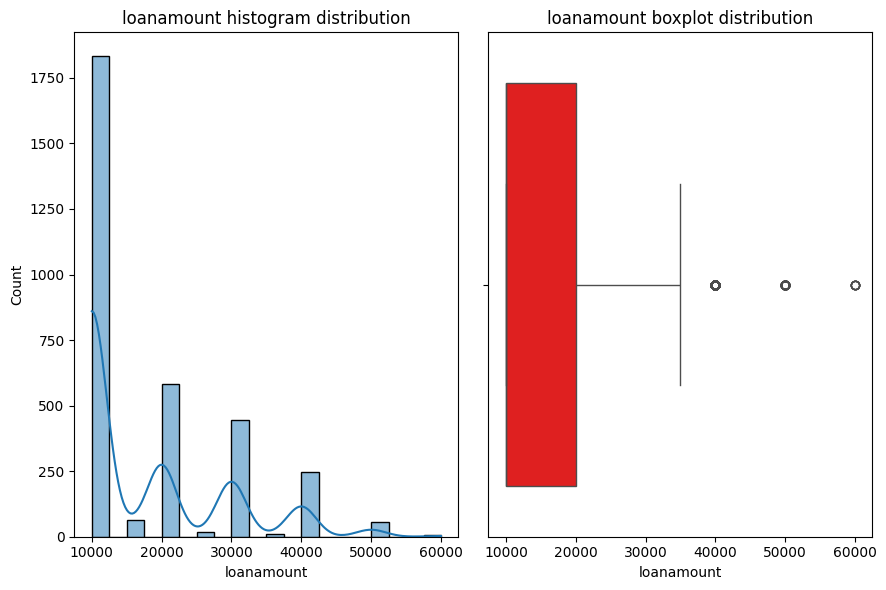

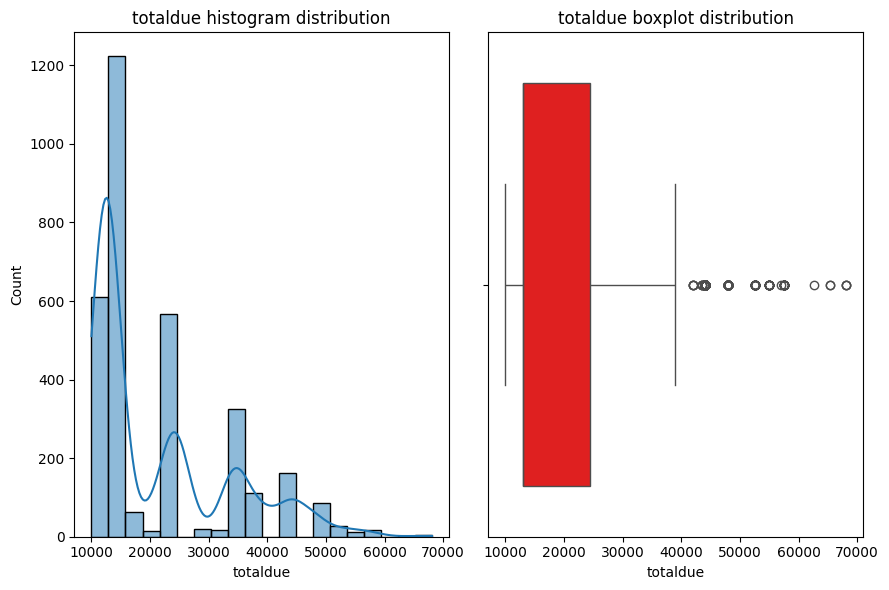

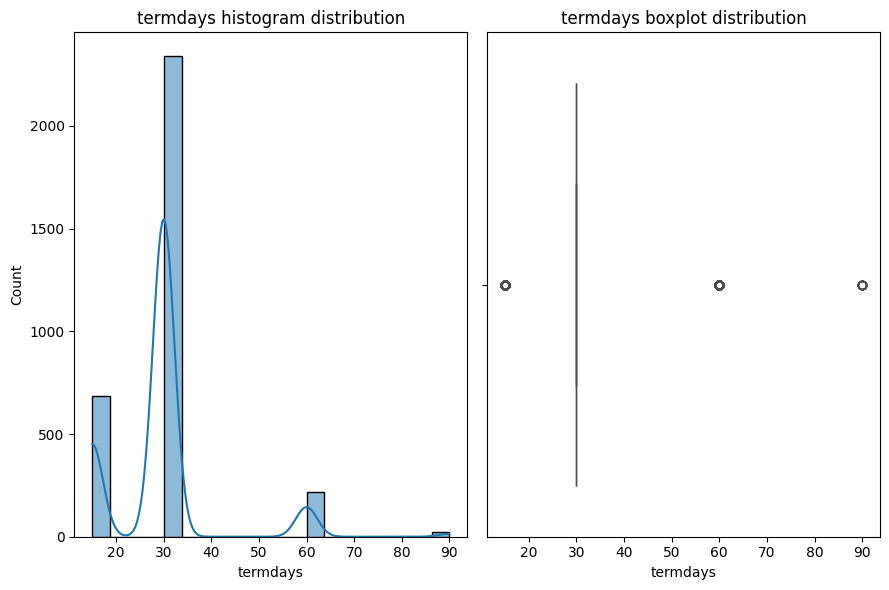

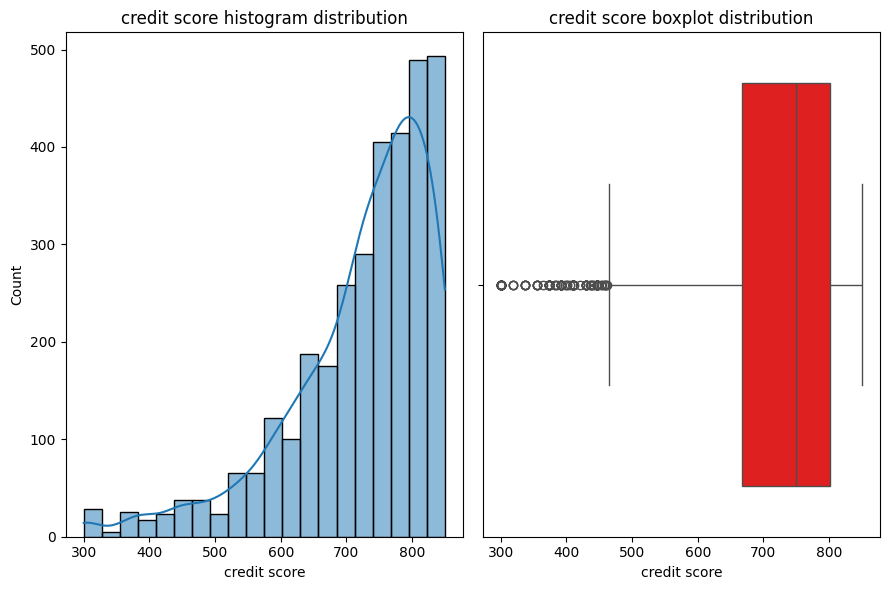

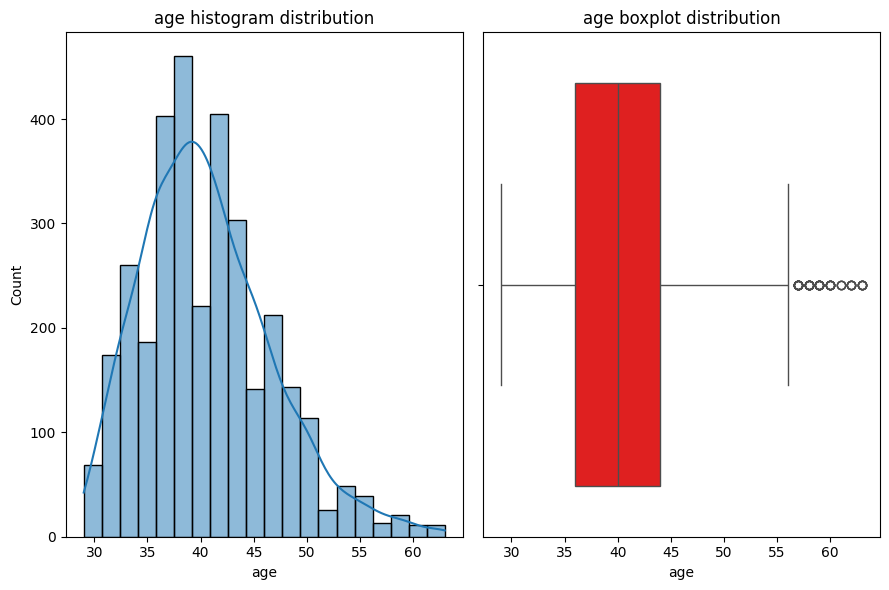

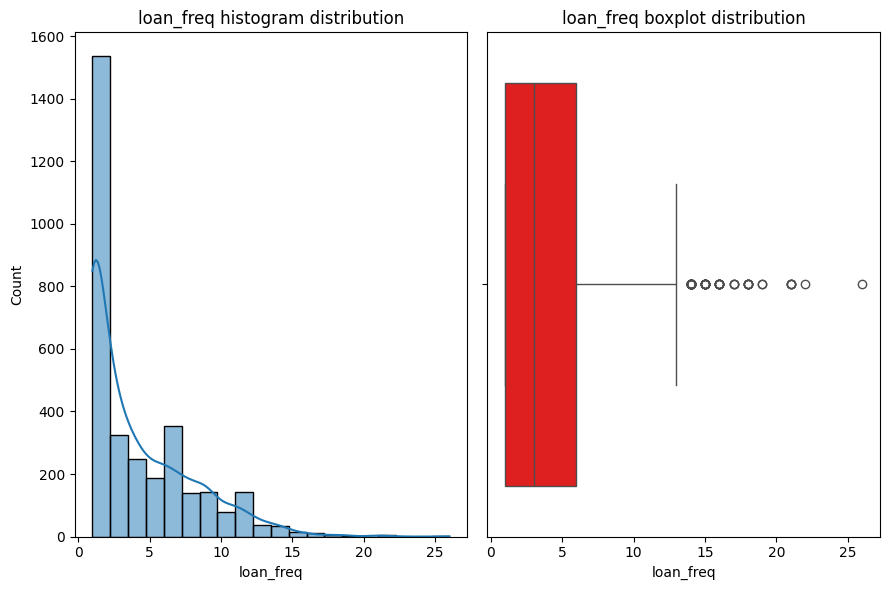

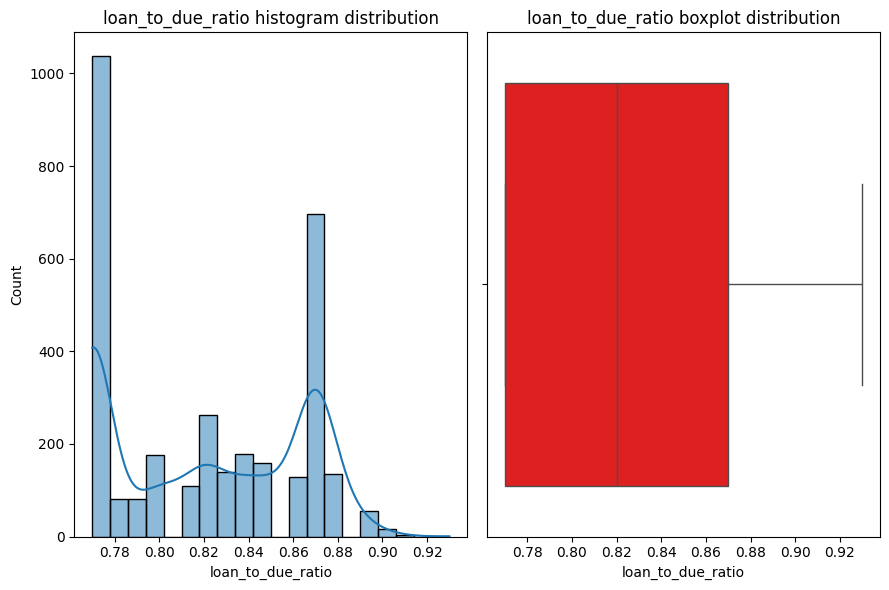

In [56]:
for num in numerical_cols:
  plt.figure(figsize=(9, 6))
  plt.subplot(1,2,1)
  sns.histplot(loan_data[num], kde=True, bins= 20)
  plt.title(f'{num} histogram distribution')
  plt.xlabel(num)
  plt.ylabel('Count')



  # boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x= loan_data[num], color= 'red')
  plt.title(f'{num} boxplot distribution')
  plt.xlabel(num)
  plt.tight_layout()
  plt.show()

All the numerical columns in the above visualization are right skewed, having outliers on the right. All except the credit score visual that is left skewed, having its outliers on the left. This behaviour suggests an imbalanced dataset.

A normalization technique would be adopted to balance the dataset in preparation for model training and prediction. (standard scaler)

##### ✔  Relationship between financials using Scatterplot/lineplot

- Credit Score vs Loan Frequency


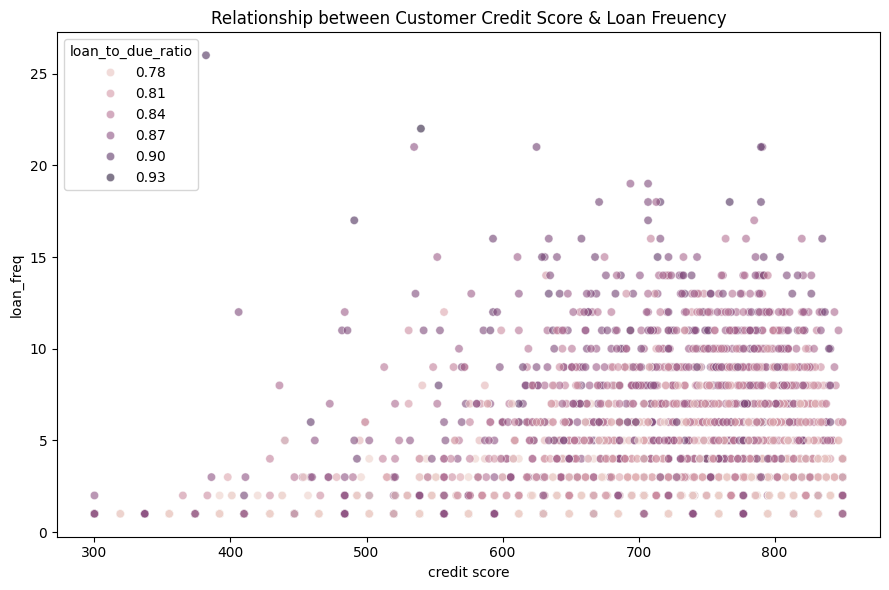

In [57]:
plt.figure(figsize=(9,6))
sns.scatterplot(loan_data, x='credit score', y='loan_freq', hue='loan_to_due_ratio',legend='auto', alpha=0.6)
plt.title('Relationship between Customer Credit Score & Loan Freuency')
plt.tight_layout()
plt.show()



The above visual communicates that:
1. Customers with higher credit scores correlates with having higher loan frequencies(customers with better scores are trusted, so they're allowed to borrow more often).
2. The hue points suggest that customers usually borrow amounts close to their due amounts.

3. Customers with very high loan frequencies (above 15) are rare but usually have mid-to-high credit scores.




-  Loan Amount to Loan_to_Due_Ratio


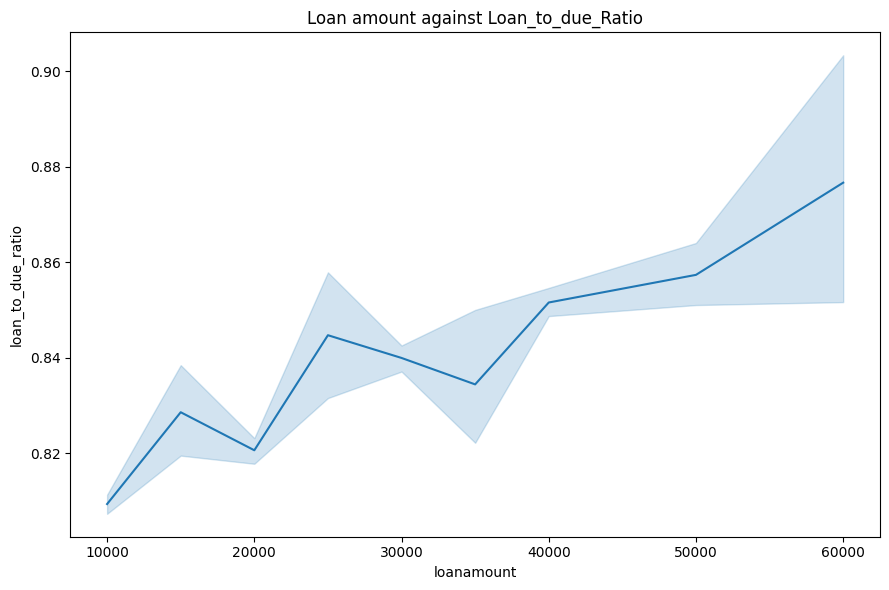

In [58]:
plt.figure(figsize=(9,6))
sns.lineplot(loan_data, x='loanamount', y='loan_to_due_ratio')
plt.title('Loan amount against Loan_to_due_Ratio')
plt.tight_layout()
plt.show()

The above visual shows a healthy customer loan repayment behaviour. Larger loans have higher ratios which means borrowers are paying on time (in relativity to the size of their loans)

##### ✔ Correlation Matrix

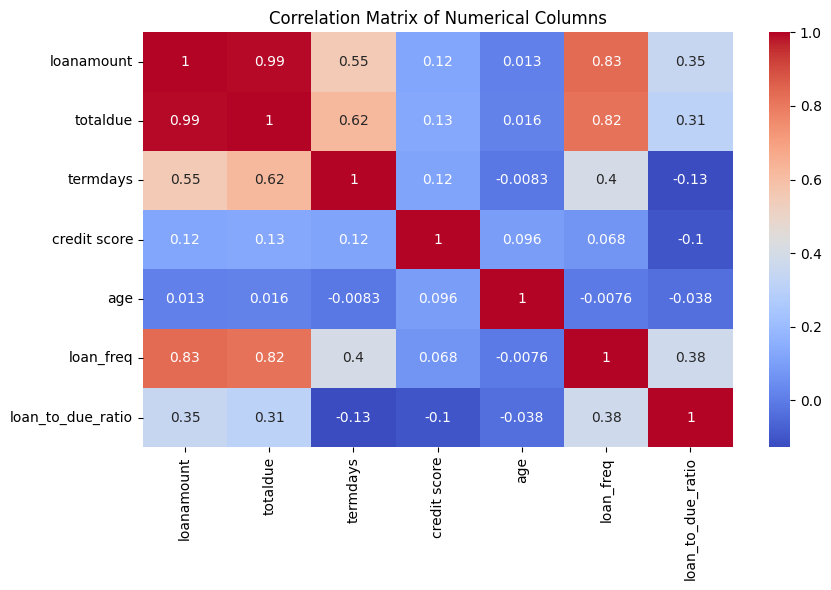

In [59]:
plt.figure(figsize=(9,6))
heatmap= loan_data[numerical_cols].corr()
sns.heatmap(heatmap, cmap='coolwarm', annot=True, cbar=True)
plt.title('Correlation Matrix of Numerical Columns')
plt.tight_layout()
plt.show()

- Theres a high correlation between *loanamount* and *totaldue*, so i will drop the *loanamount* column since *totaldue* is most likely *loanamount* plus interest and fess to reduce redundancy.
- High correlation between *loanamount* and *loan_freq*,suggesting that customers who borrow frequently take larger loans. The correlation score between *loan_freq* and *totaldue* reinforces this.
- *credit score* and *age* has a very weak correlation with most variables suggesting that it doesnt move strongly with the loan size, term days or loan frequency.




---



### 2. Numerical vs Categorical Columns

- Loan amount grouped by good_bad_flag

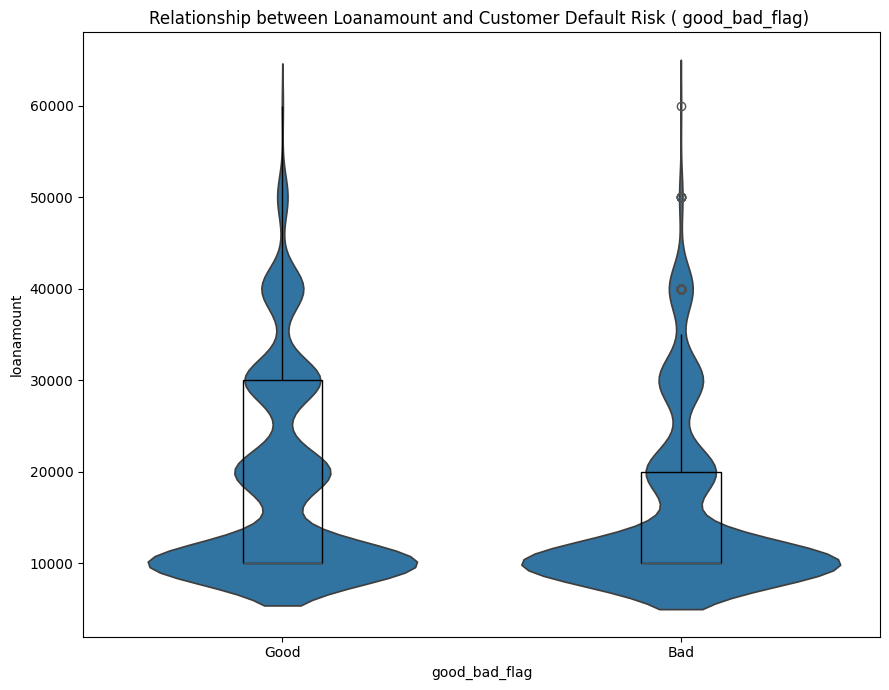

In [60]:
plt.figure(figsize=(9,7))
sns.violinplot(loan_data, x='good_bad_flag',y='loanamount', inner=None )
# boxplot overlay
sns.boxplot(loan_data, x='good_bad_flag', y='loanamount', width=0.2, showcaps=False,
            boxprops={'facecolor':'None', 'edgecolor':'black'}, whiskerprops={'color':'black'})
plt.title('Relationship between Loanamount and Customer Default Risk ( good_bad_flag) ')
plt.tight_layout()
plt.show()


From the visual above, i see that:
- Bad borrowers take lesser loan amounts. There's a higher distribution of the *bad* metric at the 10000 mark and it as it goes up, it shrinks in contrast to the *good* metric.  
- Loan amount doesn't adequately explain customer default behaviour

✔ *credit score* vs _good_bad_flag_

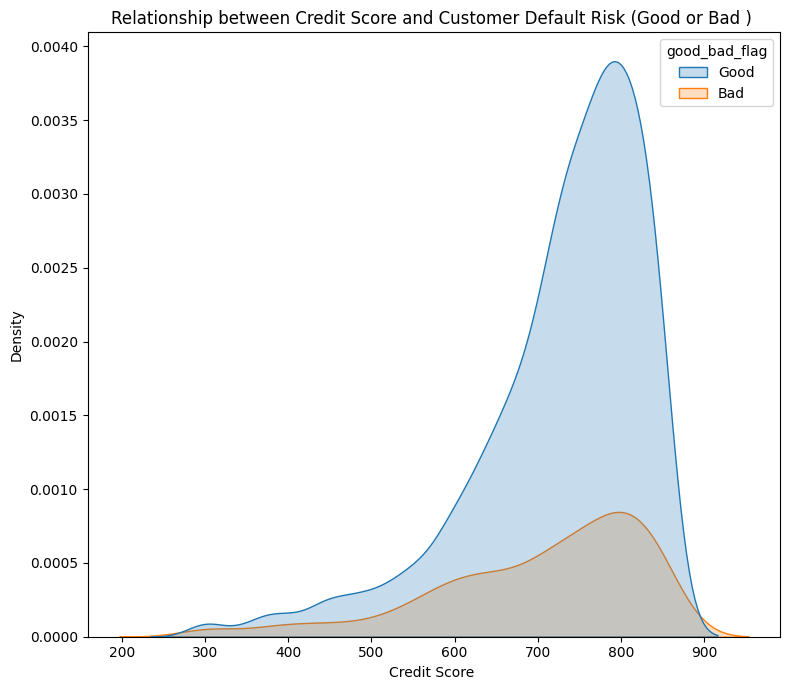

In [61]:
plt.figure(figsize=(8,7))
sns.kdeplot(data=loan_data, hue='good_bad_flag',x='credit score', fill=True)
plt.title('Relationship between Credit Score and Customer Default Risk (Good or Bad ) ')
plt.xlabel('Credit Score ')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In the above visual, we see that:
- Customers with higher credit scores are predominantly labeled as good in the good_bad_flag, telling that credit score is an important feature in determining good and bad repayment behaviour.



     



---
###3. Visualization of Categorical Columns

First, I would create a dataframe containing a unique combination of the categorical columns, with the freq column communicating how many customers fall into a particular combination.
Then, I would create the visual using sunburst plots.


In [62]:
grouped_counts = loan_data.groupby([
    'bank_account_type',
    'bank_name_clients',
    'employment_status_clients',
    'bank_branch_state',
    'bank_branch_country',
    'age group',
    'good_bad_flag'
])['age'].count().reset_index(name='freq')


In [63]:
grouped_counts.sample(4)

,bank_account_type,bank_name_clients,employment_status_clients,bank_branch_state,bank_branch_country,age group,good_bad_flag,freq
765,Savings,Skye Bank,Permanent,Lagos,Nigeria,Middle-aged Adult,Good,1
149,Other,First Bank,Self-Employed,Niger,Nigeria,Old-aged Adult,Good,1
156,Other,First Bank,Student,Bauchi,Nigeria,Old-aged Adult,Good,1
834,Savings,Sterling Bank,Permanent,Oyo,Nigeria,Old-aged Adult,Bad,1


Sunburst Plot

In [64]:
  # color based on good/bad category
fig1 = px.sunburst(grouped_counts, path=['bank_account_type',
    'employment_status_clients',
    'age group',
    'good_bad_flag'], values='freq', color='good_bad_flag', color_discrete_sequence=px.colors.qualitative.Antique_r
        )

# color based on freq
fig2 = px.sunburst(grouped_counts, path=['bank_account_type',
    'employment_status_clients',
    'age group',
    'good_bad_flag'], values='freq', color='freq', color_continuous_scale=px.colors.sequential.Viridis_r
                  )

fig = make_subplots(rows =1, cols = 2, specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles = ('Categorical (Good vs Bad)', 'Frequency (Record Counts)')
)

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.update_layout(
    title_text= "Sunburst Plot of Categorical Columns (except location data)",
        title_x= 0.5,
        width=1800,
        height= 900,
    margin=dict(t=80, l=20, r=20, b=20 )
)
fig.show()

From the sunburst plot, we see that:
- A larger percentage of good borrowers own a savings account, are in the old-aged age group(older than 45), and work permanent jobs.
- The second largest group of good borrowers fall under the 'Other' account type category, perhaps they own domicillary accounts
- Bad borrowers are present but not dominant, indicating imbalance.
- Customers under the students and self-employed segments are underrepresented in this dataset.
- The target column (*good_bad_flag*), and dataset overall, is imbalanced. A larger percentage of the customers fall under the good, and for accurate predictions, this must be equalized.


###  Visualization of GPS coordinates & Location Data

In [65]:
# To get customer density
grouped_location = loan_data.groupby(['bank_name_clients', 'bank_branch_state', 'bank_branch_country', 'latitude_gps', 'longitude_gps']).size().reset_index(name='customer_count')

In [66]:
map_fig = px.scatter_mapbox(
    grouped_location,
    lat ='latitude_gps',
    lon = 'longitude_gps',
    size='customer_count',
    title ='Distribution of Client Banks and Customer Density',
    color = 'bank_name_clients',
    color_continuous_scale= 'Virdis',
    hover_name='bank_name_clients',
    hover_data=['bank_branch_state', 'bank_branch_country'],
    zoom= 5,
    height=800
)
map_fig.update_layout(mapbox_style='open-street-map')
map_fig.show()

From the map visual, we see that:
- There is a high customer density in the southern region of Nigeria, this could influence higher loan uptakes and customer repaymenet behaviour.
- Banks with the most branches are Zenith, UBA, Accessbank and Firstbank.
- Saturation of customer clusters in urban areas like Lagos, Abuja, Port Harcourt, may influence the intensity of loan demand and repayment behaviour.

### Data Preprocessing

In [67]:
loan_data.columns

Index(['bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients',
       'level_of_education_clients', 'loannumber', 'loanamount', 'totaldue',
       'termdays', 'good_bad_flag', 'credit score', 'loan_freq',
       'loan_to_due_ratio', 'bank_branch_state', 'bank_branch_country', 'age',
       'age group'],
      dtype='object')

In [68]:
x= loan_data.drop(columns= ['good_bad_flag'])
y = loan_data['good_bad_flag']

In [69]:
print(type(x))

<class 'pandas.core.frame.DataFrame'>


In [70]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify =y,

                                                    random_state=56)

In [71]:

num_cols = [
    'loannumber',
    'loanamount',
    'totaldue',
    'termdays',
    'credit score',
    'loan_freq',
    'loan_to_due_ratio',
    'age'
]

cat_cols = x_train.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_cols:
    x_train[col] = x_train[col].astype(str)
    x_test[col] = x_test[col].astype(str)

In [72]:
cat_cols

['bank_account_type',
 'bank_name_clients',
 'employment_status_clients',
 'level_of_education_clients',
 'bank_branch_state',
 'bank_branch_country',
 'age group']

In [73]:
# encode target variable
label_encod = LabelEncoder()
y_train_enc = label_encod.fit_transform(y_train)
y_test_enc = label_encod.transform(y_test)

In [74]:
print(label_encod.classes_)

['Bad' 'Good']


In [75]:
num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
    ])
cat_transformer = Pipeline(steps =
 [ ('imputer', SimpleImputer(strategy='most_frequent')),
     ('encoder', HashingEncoder(n_components=8))
 ])

ordinal_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
    ('order', OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value',
                             unknown_value=-1))
])

In [76]:
ord_cols = ['level_of_education_clients']

In [77]:
# combination of transformers

preprocessor= ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
    ('ord', ordinal_transformer, ord_cols)
])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['loannumber', 'loanamount', 'totaldue',
                                  'termdays', 'credit score', 'loan_freq',
                                  'loan_to_due_ratio', 'age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  HashingEncoder(max_process=1))]),
                                 ['bank_account_...
                                  'employment_status_clients',
                                  'level_of_education_clients',
                                  'bank_branch_state', 'bank_branch_country',
                                  'age group']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('order',
                                                  OrdinalEncoder(categories=[['Primary',
                                                                              'Secondary',
                                                                              'Graduate',
                                                                              'Post-Graduate']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['level_of_education_clients'])])

In [78]:
# define models
models = {
    'Logistic Regression Classifier': LogisticRegression(solver='liblinear',max_iter=1300, class_weight='balanced'),
    'Random Forest Classifier': RandomForestClassifier(criterion='gini', n_estimators=100,
                                                       random_state =42, class_weight='balanced'),
    'Light GBM': lgb.LGBMClassifier(random_state =42, class_weight='balanced'),
    'XGboost Classifier': XGBClassifier(random_state=42),
    'Naive Bayes Classifier': GaussianNB()
}

[LightGBM] [Info] Number of positive: 1786, number of negative: 1811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2670
[LightGBM] [Info] Number of data points in the train set: 3597, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



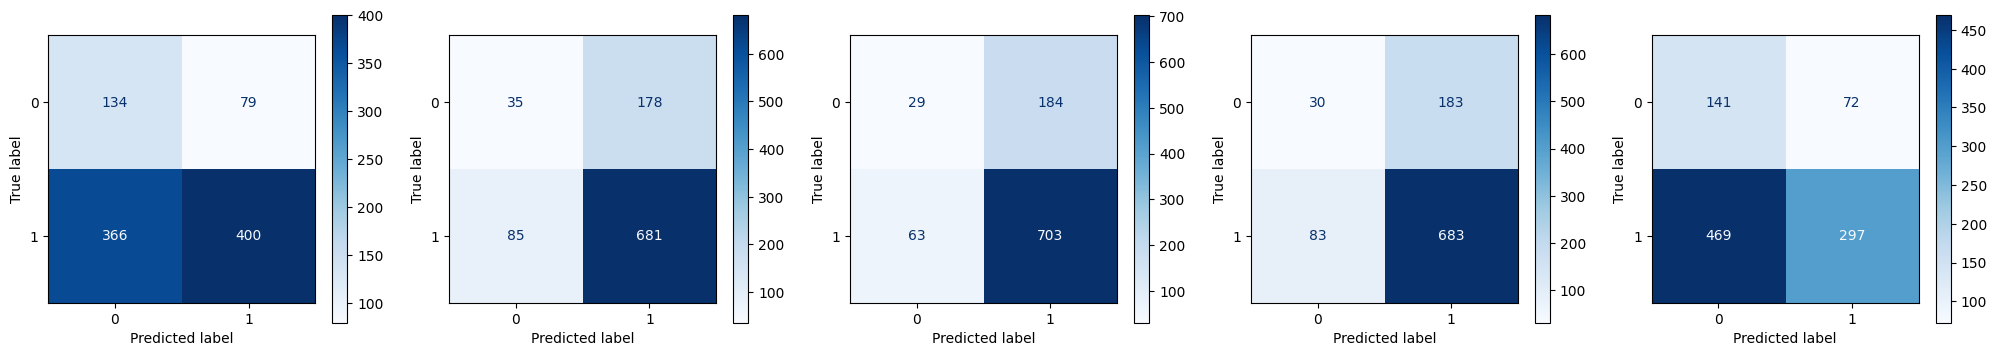

In [79]:

result = []
best_score = 0
best_model = None
best_model_name = ''
fig, axes = plt.subplots(1,5, figsize=(25,4))
# create model
for (name, model), ax in zip( models.items(), axes.flatten()):
  pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('smote', ADASYN(sampling_strategy='minority', random_state=42)),
      ('classifier', model)
  ])

  # train model
  pipeline.fit(x_train, y_train_enc)

  # predict
  train_pred = pipeline.predict(x_train)
  test_pred = pipeline.predict(x_test)

  # result of prediction
  train_acc = accuracy_score( y_train_enc, train_pred)
  test_acc = accuracy_score(y_test_enc, test_pred)
  classificationReport = classification_report(y_test_enc, test_pred, output_dict=True)



  result.append({
      'Model':name,
      'Train Accuracy': train_acc,
      'Test Accuracy': test_acc,
      'Classification Report': classificationReport,
      'Pipeline': pipeline
   })
  cm = confusion_matrix(y_test_enc, test_pred)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot(ax=ax, cmap='Blues')

 ### Confusion Matrix Plot Interpetation

where **0** = **Bad** and **1** = **Good**

#### Plot 1. Logistic Regression
- Has many false negatives so it struggles to correctly identify the 'Good' class hereby missing a lot of postives.

#### Plot 2. Random Forest Classifier
- Identifies a lot of 'Good' classes but performs poorly at catching 'Bad'.Hints at overfitting.

#### Plot 3. LightGBM
- Quite similar to Random Forest, only that it has slightly fewer false negatives compared to the latter.

#### Plot 4. XGBoost Classifier
- Better at catching the 'Bad' class, and also has strong recall for the 'Good' class.

#### Plot 5. Naive Bayes
- Catches a lot of 'Bad', terrible performance for catching the 'Good' class, it seems it predicts almost everything as 'Bad'

I suspect the best models that somewhat generalize well are XGBoost and LightGBM, they catch the most 'Good', but needs improvement on catching the 'Bad' class.



> The aim is to minimize false positives - predicting 'Bad' classes as 'Good'.




#### Evaluation Metrics on All Five Models

In [80]:
best_score = 0
best_model = None
best_model_name = ""
summary = []


for entry in result:
    test_acc = entry['Test Accuracy']
    precision = entry['Classification Report'].get('macro avg', {}).get('precision', 0)
    recall = entry['Classification Report'].get('macro avg', {}).get('recall', 0)
    macro_f1 = entry['Classification Report'].get('macro avg', {}).get('f1-score', 0)

    summary.append({
      'Model': entry['Model'],
      'Train Accuracy': round(entry['Train Accuracy'], 3),
      'Test Accuracy': round(test_acc, 3),
      'Precision': round(precision, 3),
      'Recall': round(recall, 3),
      'Macro F1-Score': round(macro_f1, 3) if macro_f1 else 'N/A'
   })

In [81]:
results_df = pd.DataFrame(summary)

In [82]:
results_df


,Model,Train Accuracy,Test Accuracy,Precision,Recall,Macro F1-Score
0,Logistic Regression Classifier,0.547,0.545,0.552,0.576,0.509
1,Random Forest Classifier,0.996,0.731,0.542,0.527,0.524
2,Light GBM,0.888,0.748,0.554,0.527,0.520
3,XGboost Classifier,0.943,0.728,0.527,0.516,0.511
4,Naive Bayes Classifier,0.461,0.447,0.518,0.525,0.433


Based off the evaluation of all five models, Logistic Regression Classifier and Light GBM perform well on the dataset. With emphasis on recall ( how well the models catch all positive cases (bad loans)).

- Logistic Regression is the most balanced model amongst all five models. Having the highest recall score of 0.580, I suspect that it would generalize the best on the dataset, and would catch more bad loaners. Its test and train accuracy scores are > 0.5 and aren't overfitted.
- LightGBM Classifier has a good test accuracy score (0.760) compared to its train accuracy score (0.888), showing a high accuracy in prediction than Logistic Regression. its F1 score, although not optimal, is strong nevertheless.


Random Forest and XGBoost classifiers have high train accuracy scores (> 0.9) but their test scores are relatively lower ( around the 0.7 - 0.75 range). I suspect overfitting and oversimplification of the both on the data.

To select the best model, I would perform **hyperparameter tuning** on both Logistic Regression and LightGBM, where their performance on the dataset would be evaluated again.

#### Hyperparameter Tuning

##### 1. LightGBM Classifier

In [83]:
# after tuning, and during evaluation, i noticed the tuned model still had a bias towards the positive class, so, i would implement cost sensitive measures to see if that would reduce
scale_pos_weight = pd.Series(y_train_enc).value_counts()[0] / pd.Series(y_train_enc).value_counts()[1]
lgb_= lgb.LGBMClassifier(
     random_state= 42, scale_pos_weight = scale_pos_weight
)
pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ADASYN', ADASYN(sampling_strategy='minority', random_state = 42)),
     ('model', lgb_)
])
param_grid_lgb = {  'model__n_estimators': randint( 300, 800),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': randint(6,10),
    'model__subsample': uniform(0.6, 0.2),
    'model__colsample_bytree': uniform(0.6, 0.2),
    'model__min_child_weight': randint(1,5)
}

random_lgb = RandomizedSearchCV(
    estimator=pipeline_lgb,
    param_distributions =param_grid_lgb,
    n_iter = 10,
    scoring = 'f1_macro',
    cv=3,
    verbose =5,
    random_state = 42, n_jobs = -1,
    error_score = 'raise'
)

random_lgb.fit(x_train, y_train_enc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 1786, number of negative: 1811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2670
[LightGBM] [Info] Number of data points in the train set: 3597, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496525 -> initscore=-0.013901
[LightGBM] [Info] Start training from score -0.013901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['loannumber',
                                                                                'loanamount',
                                                                                'totaldue',
                                                                                'termdays',
                                                                                'credit '
                                                                                'score',
                                                                                'loan_freq',
                                                                                'loan_to_due_ratio',
                                                                                'age']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImpute...
                                        'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b79fe1ddc10>,
                                        'model__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b79fe363d40>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b79fe23e330>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b79fe2177a0>},
                   random_state=42, scoring='f1_macro', verbose=5)

In [84]:
best_lgb_params = random_lgb.best_params_
best_lgb_params

{'model__colsample_bytree': np.float64(0.7028468876827223),
 'model__learning_rate': np.float64(0.06924145688620424),
 'model__max_depth': 8,
 'model__min_child_weight': 1,
 'model__n_estimators': 606,
 'model__subsample': np.float64(0.736061507717556)}

In [85]:
best_lgb_score = random_lgb.best_score_
best_lgb_score

np.float64(0.5224334981656713)

In [86]:
random_lgb.score(x_test, y_test_enc)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



0.5211834219156395

#### Evaluation of Tuned XGBoost Model using ROC & Precision, Recall Scores

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



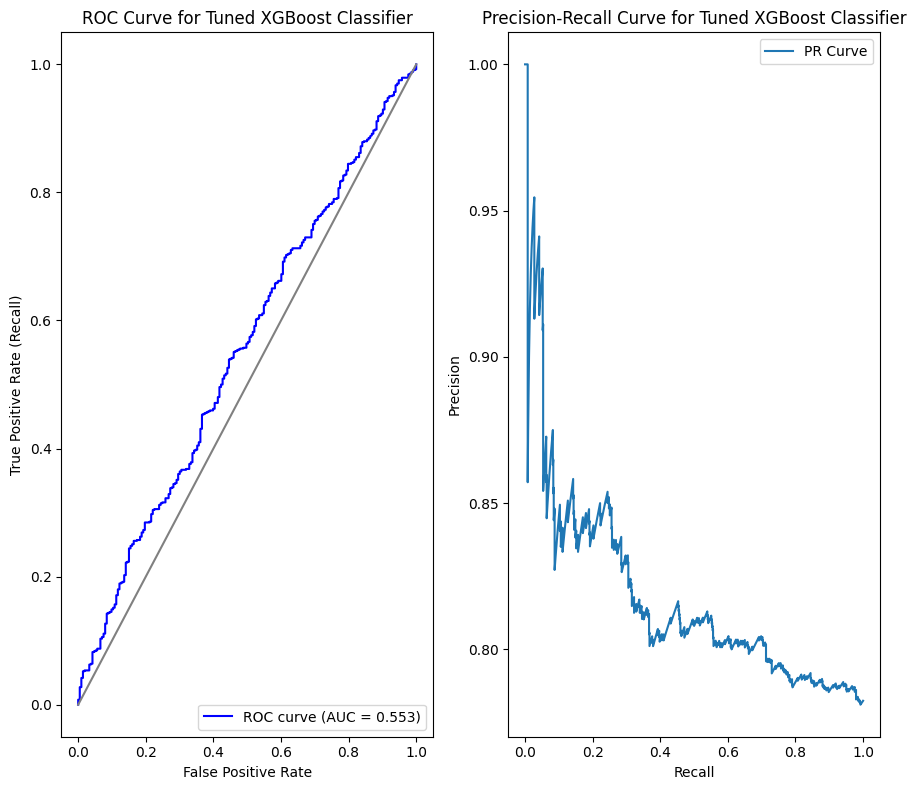

In [87]:
y_probs = random_lgb.predict_proba(x_test)[:, 1]

fpr,tpr, _ = roc_curve(y_test_enc, y_probs)
roc_auc = auc(fpr,tpr)


plt.figure(figsize=(9,8))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Tuned XGBoost Classifier')
plt.legend(loc='lower right')



precision, recall, thresholds = precision_recall_curve(y_test_enc, y_probs)
plt.subplot(1,2, 2)
plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Tuned XGBoost Classifier")
plt.legend()

plt.tight_layout()
plt.show()


f1_scores = 2 * (precision * recall) / (precision + recall)
best_thresh = thresholds[np.argmax(f1_scores)]

In [88]:
# get max threshold f1 score
thresholds_try = [ 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.82]
for threshold in thresholds_try:

  print(f'threshold {threshold:.2f}')
  y_pred= (y_probs >= threshold).astype(int)
  print(classification_report(y_test_enc, y_pred, zero_division=0))

threshold 0.75
              precision    recall  f1-score   support

           0       0.24      0.50      0.33       213
           1       0.80      0.56      0.66       766

    accuracy                           0.55       979
   macro avg       0.52      0.53      0.49       979
weighted avg       0.68      0.55      0.59       979

threshold 0.76
              precision    recall  f1-score   support

           0       0.25      0.53      0.34       213
           1       0.81      0.55      0.66       766

    accuracy                           0.55       979
   macro avg       0.53      0.54      0.50       979
weighted avg       0.69      0.55      0.59       979

threshold 0.77
              precision    recall  f1-score   support

           0       0.25      0.54      0.34       213
           1       0.81      0.55      0.65       766

    accuracy                           0.54       979
   macro avg       0.53      0.54      0.50       979
weighted avg       0.69      

##### **Observations**:
On original model training, XGBoost classifier had the following scores

- Train Accuracy - 0.889
- Test Accuracy - 	0.748
- Precison - 0.541
- Recall -	0.518
- Macro F1 Score - 0.507



Upon Hyperparameter tuning, these values only increased slightly, infact, from the classification report above and the precison-recall plot shown earlier, there is an inverse relationship between the two classes - **0 & 1** - in the precison and recall categories. This indicates that this model performs poorly on the dataset.

I need a model that properly balances both classes across all metrics. So, i would perform hyperparameter tuning on the logistic regression classifier, as it is the top performer in the five models evaluation carried out earlier.  

Ensemble method or logistic regression hyperparameter tuning?


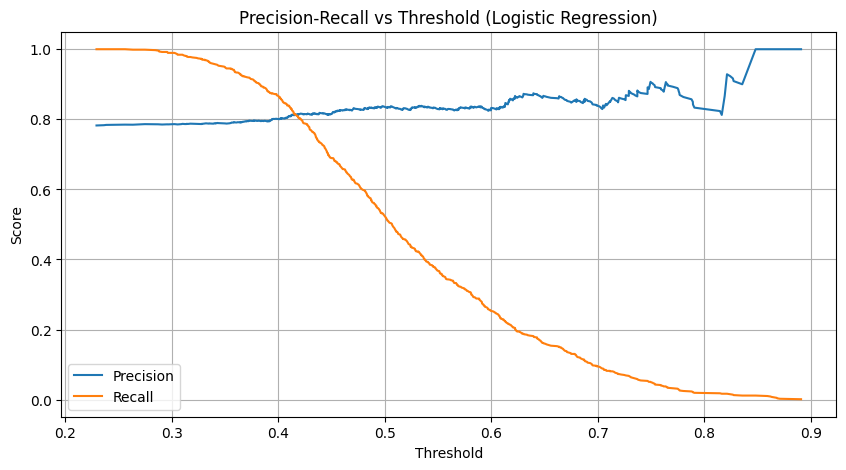

Logistic Regression Report (Threshold = 0.4):
              precision    recall  f1-score   support

           0       0.32      0.23      0.26       213
           1       0.80      0.87      0.83       766

    accuracy                           0.73       979
   macro avg       0.56      0.55      0.55       979
weighted avg       0.70      0.73      0.71       979



In [89]:

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(sampling_strategy='minority', random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000))
])

logreg_pipeline.fit(x_train, y_train_enc)
# Predict probabilities
logreg_probs = logreg_pipeline.predict_proba(x_test)[:, 1]

#  precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_enc, logreg_probs)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')

plt.title('Precision-Recall vs Threshold (Logistic Regression)')
plt.legend()
plt.grid()
plt.show()


threshold = 0.4
logreg_preds = (logreg_probs >= threshold).astype(int)

print(f"Logistic Regression Report (Threshold = 0.4):")
print(classification_report(y_test_enc, logreg_preds))



### Comparison of Classification Reports of LightGBM and Logistic Regression Classifiers

In [90]:
# lightGBM at threshold 0.79
lgb_preds=(y_probs >= 0.79).astype(int)
lgb_report = classification_report(y_test_enc, lgb_preds, output_dict = True, zero_division=0)
lgb_precision = lgb_report['macro avg']['precision']
lgb_recall = lgb_report['macro avg']['recall']
lgb_f1score = lgb_report['macro avg']['f1-score']

# logistic regression at threshold 0.4
log_preds = (logreg_probs >=0.4).astype(int)
log_report = classification_report(y_test_enc, log_preds, output_dict = True, zero_division = 0)
log_precision = log_report['macro avg']['precision']
log_recall = log_report['macro avg']['recall']
log_f1score = log_report['macro avg']['f1-score']


In [91]:

lgb_df = pd.DataFrame({
    'Model' : ['LightGBM (0.79)'],
    'Precision': [lgb_precision],
    'Recall': [lgb_recall],
    'F1 - Score': [lgb_f1score]
    })


logreg_df =pd.DataFrame({
  'Model' : ['LogReg (0.4)'],
  'Precision':[log_precision],
  'Recall':[log_recall],
  'F1 - Score':[log_f1score]
})

In [92]:

combined_df = pd.concat([lgb_df, logreg_df], ignore_index = True)
# print(combined_df[['Model', 'precision', 'recall', 'f1-score', 'support']])
combined_df


,Model,Precision,Recall,F1 - Score
0,LightGBM (0.79),0.527280,0.540050,0.488858
1,LogReg (0.4),0.560483,0.546096,0.548532


Having tried to tune two models, Logistic Regression and LightGBM classifiers, i observed that both models performed sub-optimally on the 'bad' class (class 0), but very well on the 'good' class (class 1).

I suspect that this is a fault from the dataset because i tried resampling techniques like SMOTE, then i switched to ADASYN, and i also tried adding class weights to the models (for xgb - cost sensitivity, for logistic regression - balanced class weights), and yet their performance only increased by a little over 0.01.

That being stated, i choose the Logistic Regsression model as the final estimator. and here are my reasons:
1. It generalizes well, having sigifivsntly higher recall and f1 scores.
2. It catches a lot of 'bad' loaners than the other models. this is important for our task because we need to ensure that loans aren't given to customers who have a bad track record of loan behaviour.
3. Proritizing balance, the model performs well overall.

### Feature Importance (Using SHAP plot)



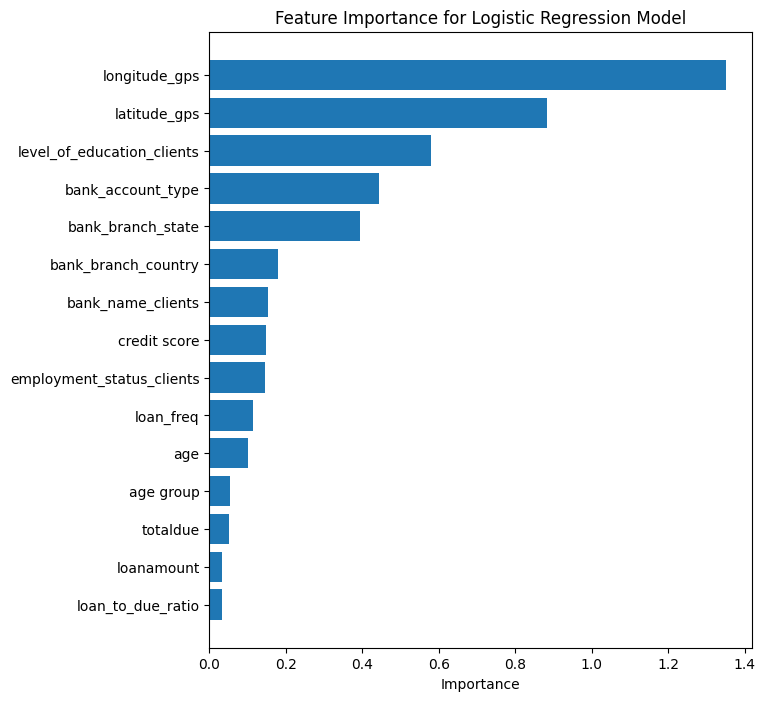

In [93]:
preprocessor = logreg_pipeline.named_steps['preprocessor']
classifier = logreg_pipeline.named_steps['classifier']

# get feature names
feature_names = logreg_pipeline.feature_names_in_
  # get importances
importances = abs(classifier.coef_).ravel()


df = pd.DataFrame({
    'Names':feature_names,
    'Importances': importances
}).sort_values(by='Importances', ascending=False)

top_10 = df.head(15).copy()
top_10['Cumulative %'] = top_10['Importances'].cumsum() / top_10['Importances'].sum() * 100


  # plot feature importance
plt.figure(figsize=(7,8))
plt.barh(top_10['Names'], top_10['Importances'])
plt.title(f'Feature Importance for Logistic Regression Model')
plt.xlabel('Importance')
plt.gca().invert_yaxis()



#### Interpretation of Feature Importance Plot

The most significant features that influence the models predictions are the location coordinates, then the bank datas and clients education level follow in the ranking.

Surprisingly, columns containing financial data don't influence the models performance as highly as i thought it would.  

These columns were useful for data exploration and analysis though, but are redundant for the models prediction.

features with an importance score < 0.2 would be dropped from the dataset as they barely influence the models performance.

###### Drop Irrelevant Features & Re-train Model
- drop columns
- redefine transformers so they work with the updated data
- rebuild the preprocessor
- retrain pipeline

In [97]:
loan_data.columns

Index(['bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients',
       'level_of_education_clients', 'loannumber', 'loanamount', 'totaldue',
       'termdays', 'good_bad_flag', 'credit score', 'loan_freq',
       'loan_to_due_ratio', 'bank_branch_state', 'bank_branch_country', 'age',
       'age group'],
      dtype='object')

In [100]:
target = 'good_bad_flag'
drop_cols = ['loannumber', 'loanamount', 'totaldue',
       'termdays', 'loan_to_due_ratio', 'age group']

feature_cols = [col for col in loan_data.columns if col not in drop_cols + [target]]

num_cols = [col for col in loan_data[feature_cols].select_dtypes(include=['int64','float64']).columns if col not in drop_cols]
cat_cols=[col for col in loan_data[feature_cols].select_dtypes(include=['object','category']).columns if col not in drop_cols]
ord_cols = [col for col in ['level_of_education_clients'] if col not in drop_cols]

# redefine transformers
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
    ])
cat_transformer = Pipeline(steps =
 [ ('imputer', SimpleImputer(strategy='most_frequent')),
     ('encoder', HashingEncoder(n_components=8))
 ])

ordinal_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
    ('order', OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value',
                             unknown_value=-1))
])

# preprocessor

preprocessor= ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
    ('ord', ordinal_transformer, ord_cols)
])

x_train =x_train[feature_cols]
x_test = x_test[feature_cols]


    #  retrain model
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(sampling_strategy='minority', random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000))
])

logreg_pipeline.fit(
    x_train,y_train_enc
)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude_gps',
                                                   'latitude_gps',
                                                   'credit score', 'loan_freq',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   HashingEncoder(max_process=1))]),
                                                  ['bank_account_type'...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('order',
                                                                   OrdinalEncoder(categories=[['Primary',
                                                                                               'Secondary',
                                                                                               'Graduate',
                                                                                               'Post-Graduate']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['level_of_education_clients'])])),
                ('adasyn',
                 ADASYN(random_state=42, sampling_strategy='minority')),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

### Model Training on Test Data & Deployment

In [101]:
# save model
final_model = logreg_pipeline

joblib.dump(final_model,'loan_model.pkl')


['loan_model.pkl']

Model Deployment on Streamlit

In [105]:
%%writefile deploy.py

import joblib
import pandas as pd
import numpy as np
import streamlit as st
import requests


# forward geocding from state and countyr input
# get API key
try:
    API_KEY = st.secrets['API_KEY']
except Exception:
    API_KEY = os.getenv('API_KEY')

def forwardgeocode(address, api_key ):
  url= f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={api_key}"
  response = requests.get(url)

  if response.status_code ==200:
      result = response.json()
      if 'results' in result and len(result['results']) > 0:
          location = result['results'][0]['geometry']['location']
          return location['lat'], location['lng']
      else:
           return None, None
  else:
       return None, None

# country list
countries = [
    'Nigeria', 'United States', 'United Kingdom', 'Ghana',
    'United Arab Emirates', "Côte d'Ivoire", 'Thailand', 'Russia',
    'Benin', 'Niger', 'China', 'Australia'
]

# States by country
states_by_country = {
    "Nigeria": [
        'Lagos', 'Ogun State', 'Delta', 'Federal Capital Territory',
        'Rivers', 'Imo', 'Gombe', 'Akwa Ibom', 'Oyo', 'Nasarawa', 'Ondo',
        'Edo', 'Abia', 'Cross River', 'Niger', 'Taraba', 'Kaduna',
        'Ìpínlẹ̀ Ògùn', 'Ìpínlẹ̀ Èkó', 'Kwara', 'Osun', 'Anambra',
        'Ekiti', 'Benue', 'Kano', 'Enugu', 'Bayelsa', 'Jigawa', 'Agege',
        'Kogi', 'Plateau', 'Ebonyi', 'Adamawa', 'Katsina', 'Igbaga',
        'Borno', 'Ìpínlẹ̀ Ọ̀yọ́', 'Bauchi', 'Auaba', 'Igbile', 'Kebbi',
        'Bakatari', 'Ìpínlẹ̀ Kwárà', 'Sokoto', 'Zamfara'
    ],
    "United States": [
        'California', 'Georgia', 'Texas', 'New York', 'Kansas', 'Ohio',
        'Maryland', 'Arkansas'
    ],
    "United Kingdom": [
        'Northern Ireland', 'England', 'Scotland', 'Wales'
    ],
    "Ghana": [
        'Greater Accra Region'
    ],
    "United Arab Emirates": [
        'Sharjah', 'Dubai', 'دبي'
    ],
    "Côte d'Ivoire": [
        "District Autonome d'Abidjan"
    ],
    "Thailand": [
        'Krung Thep Maha Nakhon'
    ],
    "Russia": [
        'Krasnoyarsk Krai'
    ],
    "Benin": [
        'Ouémé Department', 'Littoral Department'
    ],
    "Niger": [
        'Tahoua'
    ],
    "China": [
        'Bei Jing Shi'
    ],
    "Australia": [
        'New South Wales'
    ]
}

banks = ['GT Bank', 'Sterling Bank', 'Fidelity Bank', 'Access Bank',
       'EcoBank', 'FCMB', 'Skye Bank', 'UBA', 'Diamond Bank',
       'Zenith Bank', 'First Bank', 'Union Bank', 'Stanbic IBTC',
       'Standard Chartered', 'Heritage Bank', 'Keystone Bank',
       'Unity Bank', 'Wema Bank']



# Streamlit APP
model = joblib.load('loan_model.pkl')
st.title ('Customer Loan Default Risk Predictor')

st. write('Provide Customer Details: ')
country = st.selectbox('Bank Branch COuntry', countries)
state = st.selectbox('Bank Branch State', states_by_country[country])
bank_name = st.selectbox('Customers Client Bank', banks)
account_type = st.selectbox('Account Type', ["Savings", "Current", 'Other'])
employment_status = st.selectbox('Employment Status', ['Permanent', 'Student', 'Self-Employed', 'Unemployed', 'Retired',
       'Contract' ])
education_level = st.selectbox('Level of Education', ['Graduate', 'Secondary', 'Post-Graduate', 'Primary'])

credit_score = st.number_input("Credit Score", min_value=300, max_value=850, step=1)
age = st.number_input("Age", min_value=18, max_value=100, step=1)
loan_freq = st.number_input('Loan Frequency', min_value = 1, step= 1)



# predictions
if st.button('Predict'):
  fulladdress = f'{state}, {country}'
  lat, lon = forwardgeocode(fulladdress, API_KEY)

  if lat is None or lon is None:
    st.error("Couldn't fetch coordinates for given state/country. Please crosscheck entry")
  else:
    features_data ={
        "bank_account_type": account_type,
            "longitude_gps": lon,
            "latitude_gps": lat,
            "bank_branch_state": state,
            "bank_branch_country": country,
            "employment_status_clients": employment_status,
            "level_of_education_clients": education_level,
        "bank_name_clients": bank_name,
            "credit score": credit_score,
            "age": age,
        "loan_freq": loan_freq
    }

    x= pd.DataFrame([features_data])
    prediction = model.predict(x)
    if prediction[0] == 0:
      st.error("Prediction: Default (Bad Credit Risk)")
    else:
      st.success("Prediction: No Default (Good Credit Risk)")



Overwriting deploy.py


requirements.txt file for streamlit deployment

In [103]:
%%writefile requirements.txt

streamlit
pandas
numpy
scikit-learn
imbalanced-learn
category_encoders
joblib
requests


Writing requirements.txt


## [See Depolyed Project]('https://loan-risk-predictor-vq9dqvzkmu6bm6jz86usxh.streamlit.app/)